# [Notebook title]

## Context
### Purpose
*Describe the purpose of the use case.*

### Description
*Describe the main features of the dataset/sensor, preprocessing, modelling or postprocessing routine*

### Highlights
*Provide 3-5 bullet points that convey the use case’s core procedures. Each bullet point must have a maximum of 85 characters, including spaces.*
* Highlight 1
* Highlight 2

### Contributions
*Please indicate key contributions. Notebook authors (mandatory). Optional subheadings, used in published EDS book notebooks, are Dataset originator/creator, Dataset authors, Dataset documentation, Modelling codebase, Modelling publications, Modelling funding and Pipeline documentation. Feel free to add any of them or propose new ones to attribute relevant research contributions.*

#### Notebook
* Author (role), Affiliation, GitHub alias

:::{note}
*Optional: add credits or acknowledgements to data and/or model providers or authors of code snippets*
:::

## Load libraries
List libraries according to their role e.g. system/files manipulation i.e. os (first), data handling i.e. numpy, xarray (second), visualisation i.e. holoviews (third), etc. The cell below contains two libraries, `os` and `warning` which are common among the Python Jupyter notebooks. Don't remove them.*

In [1]:
import gc

In [1]:
#!/usr/bin/env python
# coding: utf-8
# 
# Script written by Rachel Furner
# Plots instantaneous fields from MITgcm dataset, for 
# various cross sections

import sys
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

sys.path.append('../src/general/')
import Model_Plotting as SecPlt

from constants import *

from netCDF4 import Dataset

In [3]:
#-----------------------------------------------
# Read in netcdf file and get shape
#-----------------------------------------------
print('Reading in ds ...')

def load_data(path_data):
    
    print('Reading in ds ...')
    da = xr.open_dataset(path_data)
    # Apply the Mask
    dam = np.where(
        da['Mask']==1, 
        da['Ttave'][time:time+2,:,:,:],
        np.nan
    )
    print(f'Shape: {dam.shape}')

    return dam, da

dam, da = load_data(path_data)
da_x, da_y, da_z = da['X'], da['Y'], da['Z']
z_size, y_size, x_size = dam.shape[1], dam.shape[2], dam.shape[3]


Reading in ds ...
Reading in ds ...
Shape: (2, 42, 78, 11)


In [4]:
#--------------------------------------------------
# Set up bits to plot diffs between time t and t+1
#--------------------------------------------------

depth_arange = [0, 7, 15, 21, 28, 37, da_z.values.shape[0]-1]
min_value = min(
    np.nanmin(dam[0:,:,x_coord]), 
    np.nanmin(dam[1:,:,x_coord]),
    np.nanmin(dam[0,level,:,:]),
    np.nanmin(dam[1,level,:,:]),
    np.nanmin(dam[0,:,y_coord,:]), 
    np.nanmin(dam[0,:,y_coord,:]) 
)

max_value = max( 
    np.nanmax(dam[0:,:,x_coord]), 
    np.amax(dam[1:,:,x_coord]),
    np.nanmax(dam[0,level,:,:]), 
    np.amax(dam[1,level,:,:]),
    np.nanmax(dam[0,:,y_coord,:]), 
    np.amax(dam[0,:,y_coord,:]) 
)

In [40]:
def plot_depth_fields(
    select,
    min_value, 
    max_value, 
    x_label, 
    y_label, 
    lon_arange, 
    lat_arange,
    da_x, 
    da_y,
    name_o,
    lab,
    cmap
):
    fig = plt.figure(figsize=(2.5, 4.5), dpi=300 )
    ax1 = fig.add_subplot(1, 1, 1)
    im1 = ax1.pcolormesh(
        select, 
        vmin=min_value, 
        vmax=max_value, 
        edgecolors='face', 
        snap=True,
        cmap=cmap
    )
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    ax1.set_xticks(lon_arange)
    ax1.set_xticklabels(
        np.round(da_x.values[np.array(lon_arange).astype(int)], decimals=-1).astype(int)
    ) 
    ax1.set_yticks(lat_arange)
    ax1.set_yticklabels(
        np.round(da_y.values[np.array(lat_arange).astype(int)], decimals=-1).astype(int)
    ) 
    plt.text(-0.1, 0.86, lab, transform=fig.transFigure)
    plt.savefig(
        f"{plotdir}{name_o}", 
        format='eps', 
        bbox_inches = 'tight', 
        pad_inches = 0.1
    )
    
    return plt

<module 'matplotlib.pyplot' from '/srv/conda/envs/notebook/lib/python3.9/site-packages/matplotlib/pyplot.py'>

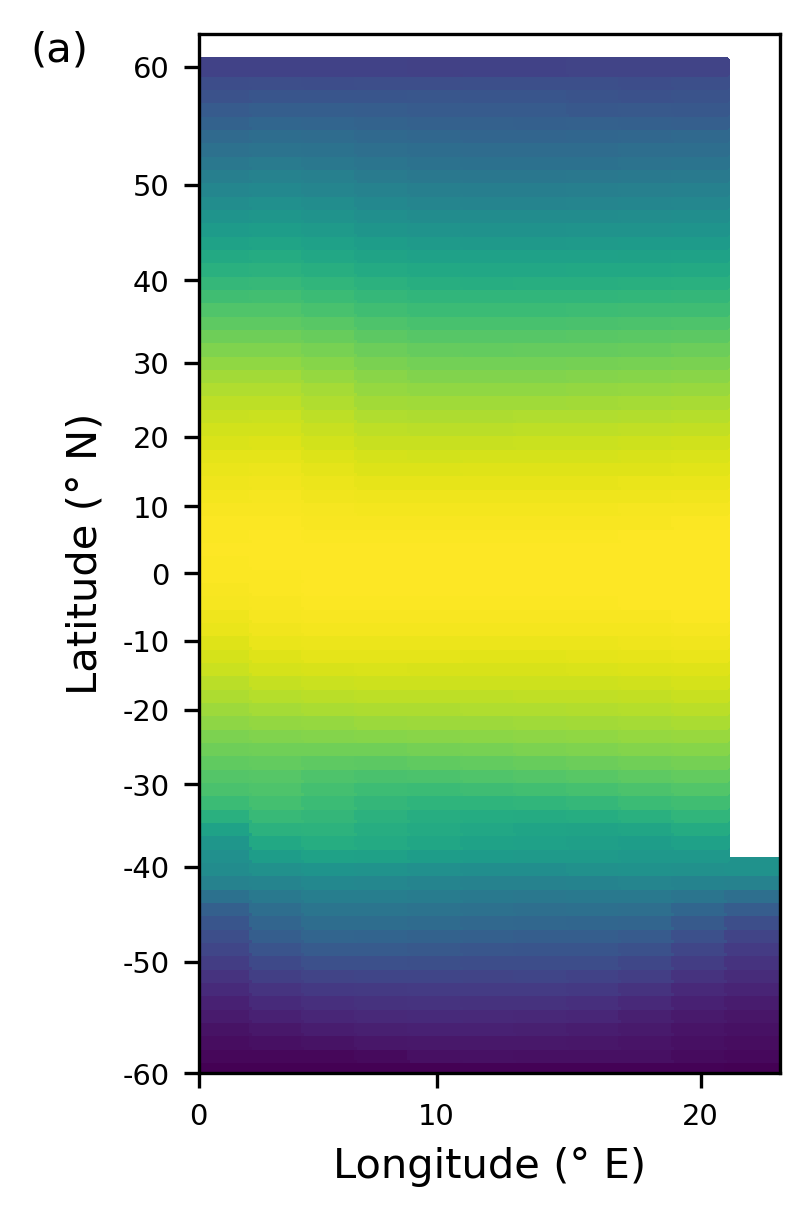

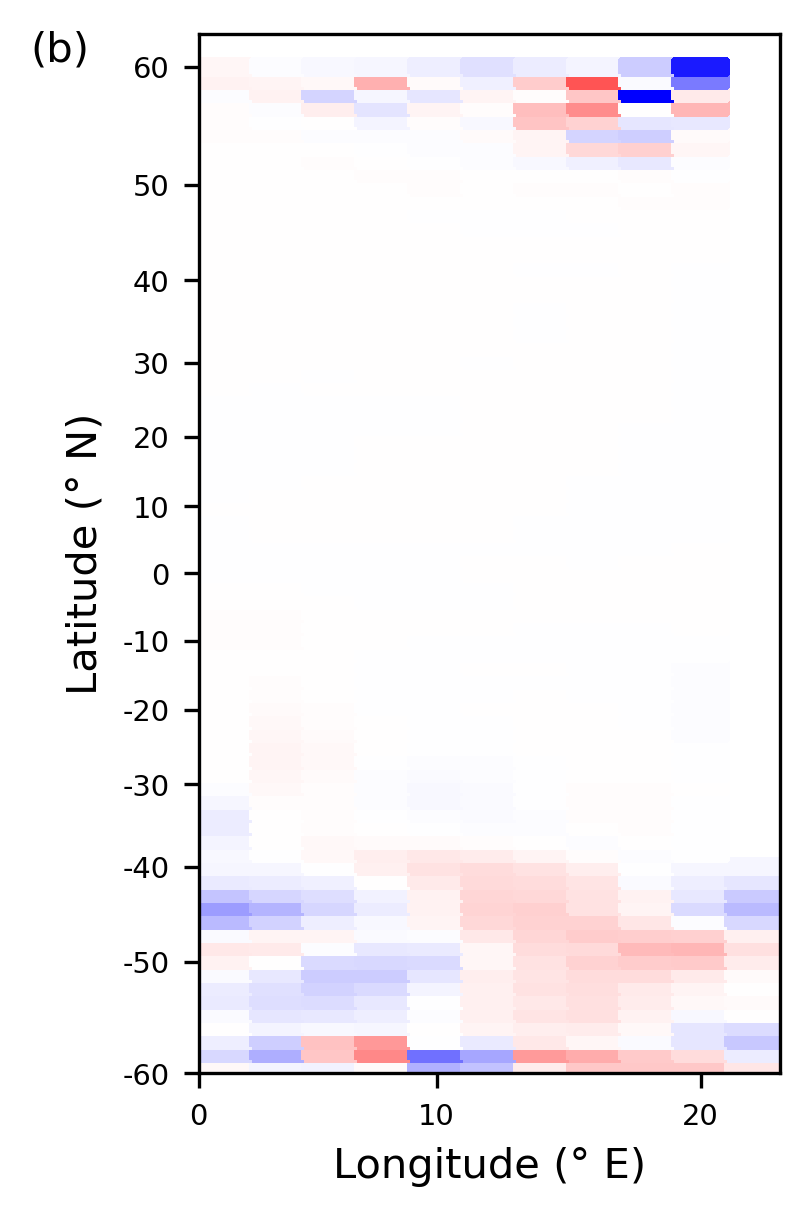

In [41]:
plot_depth_fields(
    dam[0,level,:,:],
    min_value, 
    max_value, 
    lon_label, 
    lat_label, 
    lon_arange, 
    lat_arange,
    da_x, 
    da_y,
    "fig01a.eps",
    "(a)",
    None
)

plot_depth_fields(
    dam[0,level,:,:]-dam[1,level,:,:], 
    diff_min_value, 
    diff_max_value, 
    lon_label, 
    lat_label, 
    lon_arange, 
    lat_arange,
    da_x, 
    da_y,
    "fig01b.eps",
    "(b)",
    'bwr'
    
)

In [ ]:
da_T[0,:,:,x_coord]

In [ ]:
def plot_cross_sections(
    select,
    min_value, 
    max_value,
lat_label,
depth_label,
lat_arange):
    
    ### Fig 1c ###
    fig = plt.figure(figsize=(3.6, 2.0), dpi=300)
    ax5 = fig.add_subplot(1, 1, 1)
    im5 = ax5.pcolormesh(
        select,
        vmin=min_value, 
        vmax=max_value, 
        edgecolors='face', 
        snap=True
    )
    ax5.invert_yaxis()
    ax5.set_xlabel(lat_label)
    ax5.set_ylabel(depth_label)
    ax5.set_xticks(lat_arange)
    ax5.set_xticklabels(np.round(da_y.values[np.array(lat_arange).astype(int)], decimals=-1).astype(int)) 
    ax5.set_yticks(depth_arange)
    ax5.set_yticklabels(da_z.values[np.array(depth_arange)].astype(int))
    plt.text(-0.055, 0.86, '(c)', transform=fig.transFigure)
    plt.savefig(f"{plotdir}fig01c.eps", format='eps', bbox_inches = 'tight', pad_inches = 0.1)

NameError: name 'da_T' is not defined

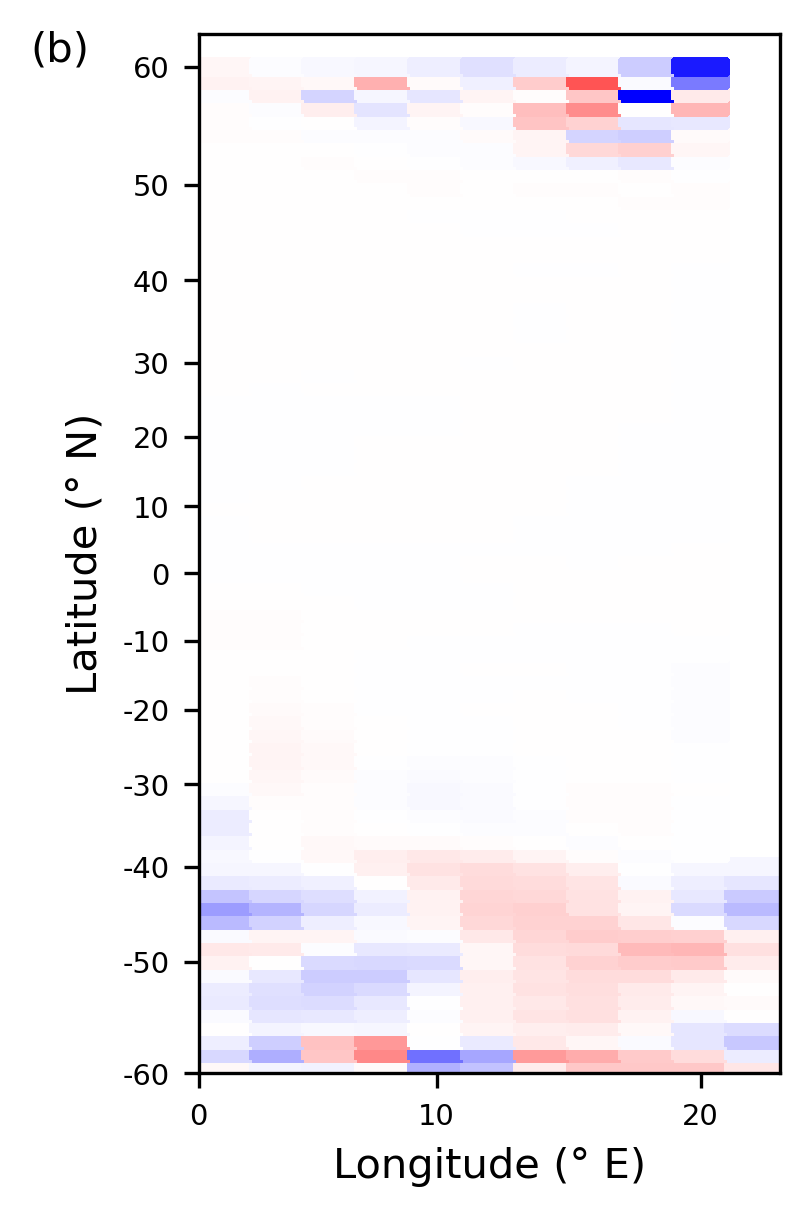

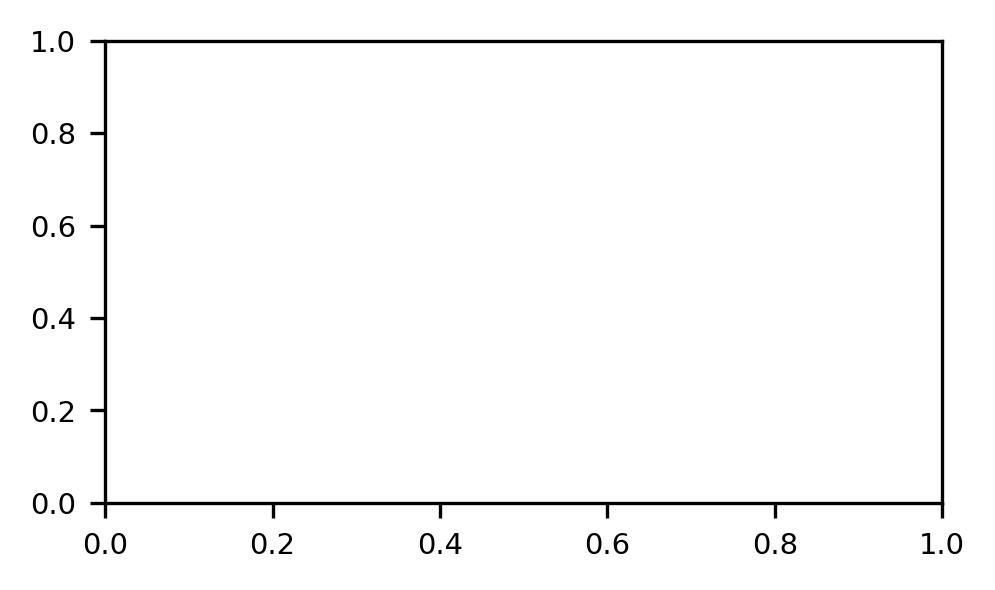

In [19]:
#---------------
# Set variables
#---------------
plt.rcParams.update({'font.size': 10})
plt.rc('font', family='sans serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')


#-----------------------------
# Plot x-const cross sections
#-----------------------------

### Fig 1c ###
fig = plt.figure( figsize=(3.6, 2.0), dpi=300 )
ax5 = fig.add_subplot(1, 1, 1)
im5 = ax5.pcolormesh(da_T[0,:,:,x_coord], vmin=min_value, vmax=max_value, edgecolors='face', snap=True)
ax5.invert_yaxis()
ax5.set_xlabel(lat_label)
ax5.set_ylabel(depth_label)
ax5.set_xticks(lat_arange)
ax5.set_xticklabels(np.round(da_y.values[np.array(lat_arange).astype(int)], decimals=-1).astype(int)) 
ax5.set_yticks(depth_arange)
ax5.set_yticklabels(da_Z.values[np.array(depth_arange)].astype(int))
plt.text(-0.055, 0.86, '(c)', transform=fig.transFigure)
plt.savefig(f"{plotdir}fig01c.eps", format='eps', bbox_inches = 'tight', pad_inches = 0.1)

### Fig 1d ###
fig = plt.figure( figsize=(3.6, 2.0), dpi=300 )
ax6 = fig.add_subplot(1, 1, 1)
im6 = ax6.pcolormesh(
    da_T[0,:,:,x_coord]-da_T[1,:,:,x_coord], 
    vmin=diff_min_value, 
    vmax=diff_max_value,
    cmap='bwr', 
    edgecolors='face', snap=True
)
ax6.invert_yaxis()
ax6.set_xlabel(lat_label)
ax6.set_ylabel(depth_label)
ax6.set_xticks(lat_arange)
ax6.set_xticklabels(np.round(da_y.values[np.array(lat_arange).astype(int)], decimals=-1).astype(int)) 
ax6.set_yticks(depth_arange)
ax6.set_yticklabels(da_Z.values[np.array(depth_arange)].astype(int))
plt.text(-0.055, 0.86, '(d)', transform=fig.transFigure)
plt.savefig(f"{plotdir}fig01d.eps", format='eps', bbox_inches = 'tight', pad_inches = 0.1)
 
#-----------------------------
# Plot y-const cross-sections
#-----------------------------

### fig 1e ###
fig = plt.figure( figsize=(3.6, 2.0), dpi=300 )
ax3 = fig.add_subplot(1, 1, 1)
im3 = ax3.pcolormesh(da_T[0,:,y_coord,:], vmin=min_value, vmax=max_value, edgecolors='face', snap=True)
ax3.invert_yaxis()
ax3.set_xlabel(lon_label)
ax3.set_ylabel(depth_label)
ax3.set_xticks(lon_arange)
ax3.set_xticklabels(np.round(da_X.values[np.array(lon_arange).astype(int)], decimals=0 ).astype(int)) 
ax3.set_yticks(depth_arange)
ax3.set_yticklabels(da_Z.values[np.array(depth_arange)].astype(int))
plt.text(-0.055, 0.86, '(e)', transform=fig.transFigure)
plt.savefig(f"{plotdir}fig01e.eps", format='eps', bbox_inches = 'tight', pad_inches = 0.1)

### fig 1f ###
fig = plt.figure( figsize=(3.6, 2.0), dpi=300 )
ax4 = fig.add_subplot(1, 1, 1)
im4 = ax4.pcolormesh(da_T[0,:,y_coord,:]-da_T[1,:,y_coord,:], vmin=diff_min_value, vmax=diff_max_value,
                     cmap ='bwr', edgecolors='face', snap=True)
ax4.invert_yaxis()
ax4.set_xlabel(lon_label)
ax4.set_ylabel(depth_label)
ax4.set_xticks(lon_arange)
ax4.set_xticklabels(np.round(da_X.values[np.array(lon_arange).astype(int)], decimals=0 ).astype(int)) 
ax4.set_yticks(depth_arange)
ax4.set_yticklabels(da_Z.values[np.array(depth_arange)].astype(int))
plt.text(-0.055, 0.86, '(f)', transform=fig.transFigure)
plt.savefig(f"{plotdir}fig01f.eps", format='eps', bbox_inches = 'tight', pad_inches = 0.1)

#-----------------
# Plot Colourbars 
#-----------------

fig = plt.figure( figsize=(3, .2), dpi=300 )
cb1axes = fig.add_axes([0.05, 0.05, 0.9, 0.9 ]) 
cb1=plt.colorbar(im1, ax=ax1, orientation='horizontal', cax=cb1axes)
cb1.set_label(cbar_label)    
plt.savefig(f"{plotdir}fig01_cb.eps", format='eps', bbox_inches = 'tight', pad_inches = 0.1)

fig = plt.figure( figsize=(3, .2), dpi=300 )
cb2axes = fig.add_axes([0.05, 0.05, 0.9, 0.9 ]) 
cb2=plt.colorbar(im2, ax=ax2, orientation='horizontal', cax=cb2axes, extend='both')
cb2.set_label(cbar_diff_label)    
cb2.formatter.set_powerlimits((-2, 2))
cb2.update_ticks()
plt.savefig(f"{plotdir}fig01_cbdiff.eps", format='eps', bbox_inches = 'tight', pad_inches = 0.1)


In [ ]:
# Script written by Rachel Furner
# Calculates average trends from various processes across 
# a dataset of MITgcm output - the trends are outputted by 
# MITgcm, and the script here reads them in and averages them

import numpy as np
import xarray as xr
import netCDF4 as nc4

#------------------
# Set up variables 
#------------------
no_points = 500  # in months/days
skip_rate = 14   # Take every skip_rate point in time, so as to avoid looking at heavily correlated points

DIR  = '../data/raw/'
data_filename=DIR+'cat_tave.nc'

#---------------------------------------------
# Read in netcdf file for shape and variables
#---------------------------------------------
print('reading in ds')
ds = xr.open_dataset(data_filename)

#-------------------------
# Set up new netcdf array
#-------------------------
print('set up netcdf file')

nc_file = nc4.Dataset('../data/AveragedMITgcmData.nc','w', format='NETCDF4') 
# Create Dimensions
nc_file.createDimension('T', None)
nc_file.createDimension('Z', ds['Z'].shape[0])
nc_file.createDimension('Y', ds['Y'].shape[0])
nc_file.createDimension('X', ds['X'].shape[0])
nc_file.createDimension('Yp1', ds['Yp1'].shape[0])
nc_file.createDimension('Xp1', ds['Xp1'].shape[0])

# Create variables
nc_T = nc_file.createVariable('T', 'i4', 'T')
nc_Z = nc_file.createVariable('Z', 'i4', 'Z')
nc_Y = nc_file.createVariable('Y', 'i4', 'Y')  
nc_X = nc_file.createVariable('X', 'i4', 'X')
nc_Yp1 = nc_file.createVariable('Yp1', 'i4', 'Yp1')  
nc_Xp1 = nc_file.createVariable('Xp1', 'i4', 'Xp1')

nc_Av_ADVr_TH = nc_file.createVariable('Av_ADVr_TH', 'f4', ('Z', 'Y', 'X'))
nc_Av_ADVx_TH = nc_file.createVariable('Av_ADVx_TH', 'f4', ('Z', 'Y', 'Xp1'))
nc_Av_ADVy_TH = nc_file.createVariable('Av_ADVy_TH', 'f4', ('Z', 'Yp1', 'X'))
nc_Av_DFrE_TH = nc_file.createVariable('Av_DFrE_TH', 'f4', ('Z', 'Y', 'X'))
nc_Av_DFrI_TH = nc_file.createVariable('Av_DFrI_TH', 'f4', ('Z', 'Y', 'X'))
nc_Av_DFxE_TH = nc_file.createVariable('Av_DFxE_TH', 'f4', ('Z', 'Y', 'Xp1'))
nc_Av_DFyE_TH = nc_file.createVariable('Av_DFyE_TH', 'f4', ('Z', 'Yp1', 'X'))
nc_Av_TOTTTEND= nc_file.createVariable('Av_TOTTTEND','f4', ('Z', 'Y', 'X'))
nc_Av_UVELTH  = nc_file.createVariable('Av_UVELTH' , 'f4', ('Z', 'Y', 'Xp1'))
nc_Av_VVELTH  = nc_file.createVariable('Av_VVELTH' , 'f4', ('Z', 'Yp1', 'X'))
nc_Av_WVELTH  = nc_file.createVariable('Av_WVELTH' , 'f4', ('Z', 'Y', 'X'))

print('fill netcdf file')   
# Calc averages and add data to netcdf file
nc_Z[:] = ds['Z'].data
nc_Y[:] = ds['Y'].data
nc_X[:] = ds['X'].data
nc_Yp1[:] = ds['Yp1'].data
nc_Xp1[:] = ds['Xp1'].data
nc_T[:] = ds['T'].data[1:no_points*skip_rate+1:skip_rate]

nc_Av_ADVr_TH[:,:,:]  = np.nanmean(np.abs(ds['ADVr_TH'].data[:no_points*skip_rate+1:skip_rate,:,:,:]), axis=0)
nc_Av_ADVx_TH[:,:,:]  = np.nanmean(np.abs(ds['ADVx_TH'].data[:no_points*skip_rate+1:skip_rate,:,:,:]), axis=0)
nc_Av_ADVy_TH[:,:,:]  = np.nanmean(np.abs(ds['ADVy_TH'].data[:no_points*skip_rate+1:skip_rate,:,:,:]), axis=0)
nc_Av_DFrE_TH[:,:,:]  = np.nanmean(np.abs(ds['DFrE_TH'].data[:no_points*skip_rate+1:skip_rate,:,:,:]), axis=0)
nc_Av_DFrI_TH[:,:,:]  = np.nanmean(np.abs(ds['DFrI_TH'].data[:no_points*skip_rate+1:skip_rate,:,:,:]), axis=0)
nc_Av_DFxE_TH[:,:,:]  = np.nanmean(np.abs(ds['DFxE_TH'].data[:no_points*skip_rate+1:skip_rate,:,:,:]), axis=0)
nc_Av_DFyE_TH[:,:,:]  = np.nanmean(np.abs(ds['DFyE_TH'].data[:no_points*skip_rate+1:skip_rate,:,:,:]), axis=0)
nc_Av_TOTTTEND[:,:,:] = np.nanmean(np.abs(ds['TOTTTEND'].data[:no_points*skip_rate+1:skip_rate,:,:,:]), axis=0)
nc_Av_UVELTH[:,:,:]   = np.nanmean(np.abs(ds['UVELTH'].data[:no_points*skip_rate+1:skip_rate,:,:,:]), axis=0)
nc_Av_VVELTH[:,:,:]   = np.nanmean(np.abs(ds['VVELTH'].data[:no_points*skip_rate+1:skip_rate,:,:,:]), axis=0)
nc_Av_WVELTH[:,:,:]   = np.nanmean(np.abs(ds['WVELTH'].data[:no_points*skip_rate+1:skip_rate,:,:,:]), axis=0)

nc_file.close()



reading in ds
set up netcdf file
fill netcdf file


In [ ]:
import os
import warnings
warnings.filterwarnings(action='ignore')

## Set project structure
*The cell below creates a separate folder to save the notebook outputs. This facilitates the reader to inspect inputs/outputs stored within a defined destination folder. Don't remove the lines below.*

In [ ]:
notebook_folder = './notebook'
if not os.path.exists(notebook_folder):
    os.makedirs(notebook_folder)

## Load data/model
*Load full dataset or model from original or mirror sources. If the license of the dataset/model permits, we suggest creating sample data (preprocessed) or model mirror for the notebook stored in a data repository e.g. Zenodo.*

## Visualisation
*Create a visual narrative of the dataset! We suggest exploring libraries suited for interactive plotting e.g. python (Holoviews, Panel, Bokeh).*

## Summary
*Provide 3-5 bullet points summarising the main aspects of the dataset and tools covered in the notebook.*

* Sentence 1 e.g. `tool-name` to perform...
* Sentence 2 e.g. `tool-name` to perform...

## Additional information
**Dataset**: Type here details of dataset(s) version.

**Codebase**: Type here details of codebase version (only for notebooks categorised under modelling/preprocesing/post-processing themes).

**License**: The code in this notebook is licensed under the MIT License. The Environmental Data Science book is licensed under the Creative Commons by Attribution 4.0 license. See further details [here](https://github.com/alan-turing-institute/environmental-ds-book/blob/master/LICENSE.md).

**Contact**: If you have any suggestion or report an issue with this notebook, feel free to [create an issue](https://github.com/alan-turing-institute/environmental-ds-book/issues/new/choose) or send a direct message to [environmental.ds.book@gmail.com](mailto:environmental.ds.book@gmail.com).

In [ ]:
from datetime import date
print(f'Last tested: {date.today()}')